# Modelo predictivo del Boardgame Rating

* Fichero: Ejercicio_Procesamiento_DatasetBGG.ipynb
* Autor: Mayra Goicochea Neyra
* Fecha: 06/11/2019
* Curso: Machine Learning
* Nombre Proyecto: Machine Learning - Asignación 01

## Introducción

El siguiente script de python analiza y elabora un modelo predictivo para estimar el rating de un juego de mesa basado en el dataset de BoardGamesGeek.
El dataset incluye caracteristicas como tiempo de juego, complejidad, temática del juego, número de jugadores, número de compradores, número de intercambios del juego de mesa, reviews, entre otros.
Se formulará un modelo de regresión lineal y se usarán técnicas de regularización.

## Data Sources

Archivo CSV: games.csv

## Libraries & Environment

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn import linear_model, model_selection, preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import cross_val_score, GridSearchCV
%matplotlib inline

## Data Pre-Processing

### Data Loading

In [2]:
pathCsv = '../Data/games_detailed_info.csv'
games = pd.read_csv(pathCsv)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


A continuación se analiza las variables que tiene el dataset.

In [3]:
print(games.columns)
print(games.shape)
print(games.size)

Index(['Unnamed: 0', 'Abstract Game Rank', 'Accessory Rank', 'Amiga Rank',
       'Arcade Rank', 'Atari ST Rank', 'Board Game Rank',
       'Children's Game Rank', 'Commodore 64 Rank', 'Customizable Rank',
       'Family Game Rank', 'Party Game Rank', 'RPG Item Rank',
       'Strategy Game Rank', 'Thematic Rank', 'Video Game Rank',
       'War Game Rank', 'alternate', 'average', 'averageweight',
       'bayesaverage', 'boardgameartist', 'boardgamecategory',
       'boardgamecompilation', 'boardgamedesigner', 'boardgameexpansion',
       'boardgamefamily', 'boardgameimplementation', 'boardgameintegration',
       'boardgamemechanic', 'boardgamepublisher', 'description', 'id', 'image',
       'maxplayers', 'maxplaytime', 'median', 'minage', 'minplayers',
       'minplaytime', 'numcomments', 'numweights', 'owned', 'playingtime',
       'primary', 'stddev', 'suggested_language_dependence',
       'suggested_num_players', 'suggested_playerage', 'thumbnail', 'trading',
       'type', 'usersr

Se eliminan variables con valor NA y no relevantes para el modelo.

In [4]:
games.drop(['Unnamed: 0', "bayesaverage",'Abstract Game Rank', 'Accessory Rank', 'Amiga Rank','Arcade Rank', 'Atari ST Rank', 
            'Board Game Rank',"Children's Game Rank", 'Commodore 64 Rank', 'Customizable Rank','Family Game Rank', 
            'Party Game Rank', 'RPG Item Rank','Strategy Game Rank', 'Thematic Rank', 'Video Game Rank',
            'War Game Rank', 'alternate','boardgameartist', 'boardgamecategory','boardgamecompilation', 
            'boardgamedesigner', 'boardgameexpansion','boardgamefamily', 'boardgameimplementation', 
            'boardgameintegration','boardgamemechanic', 'boardgamepublisher', 'description', 
            'image','median','stddev', 'suggested_language_dependence','suggested_num_players', 
            'suggested_playerage', 'thumbnail',"primary","id","maxplaytime",
            "minplaytime"], axis=1, inplace=True)

Se eliminan los valores ausentes y solo se consideran los juegos de mesa con valoración de más de 30 usuarios.

In [5]:
games = games.dropna(axis=0)
games = games[games['usersrated']>30]
games.head(3)

,average,averageweight,maxplayers,minage,minplayers,numcomments,numweights,owned,playingtime,trading,type,usersrated,wanting,wishing,yearpublished
0,7.19118,2.3399,4,10,3,16330,6866,125254,120,1685,boardgame,85332,453,4729,1995
1,7.42605,1.9247,5,8,2,16180,6950,121717,45,1477,boardgame,85052,498,5403,2000
2,7.63799,2.4220,4,8,2,14127,4881,123067,45,1977,boardgame,83486,614,7655,2008


### Data Exploration

Primero se revisa el comportamiento de la muestra con un histograma.

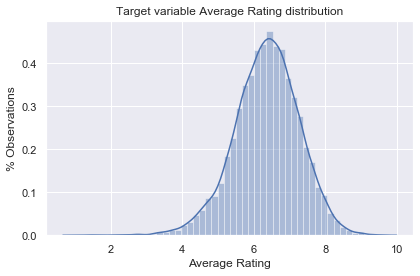

In [6]:
fig = plt.figure()
sns.set(color_codes="True")
sns.distplot(games['average'], kde=True);
plt.xlabel('Average Rating')
plt.ylabel('% Observations')
plt.title('Target variable Average Rating distribution')
plt.tight_layout()
plt.show();

A continuación, se calculan los valores medios y desviación típica.

In [7]:
y_mean = games['average'].mean()
y_std = games['average'].std()
print('Average Rating Mean {}'.format(y_mean))
print('Average Rating Standard Deviation {} \n'.format(y_std))

Average Rating Mean 6.355177413342848
Average Rating Standard Deviation 0.9087563200891718 



Se genera la matriz de correlación.

In [8]:
corr_matrix = games.corr()
games_dummy = pd.get_dummies(games.type)
games = pd.concat([games, games_dummy], axis = 1)
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

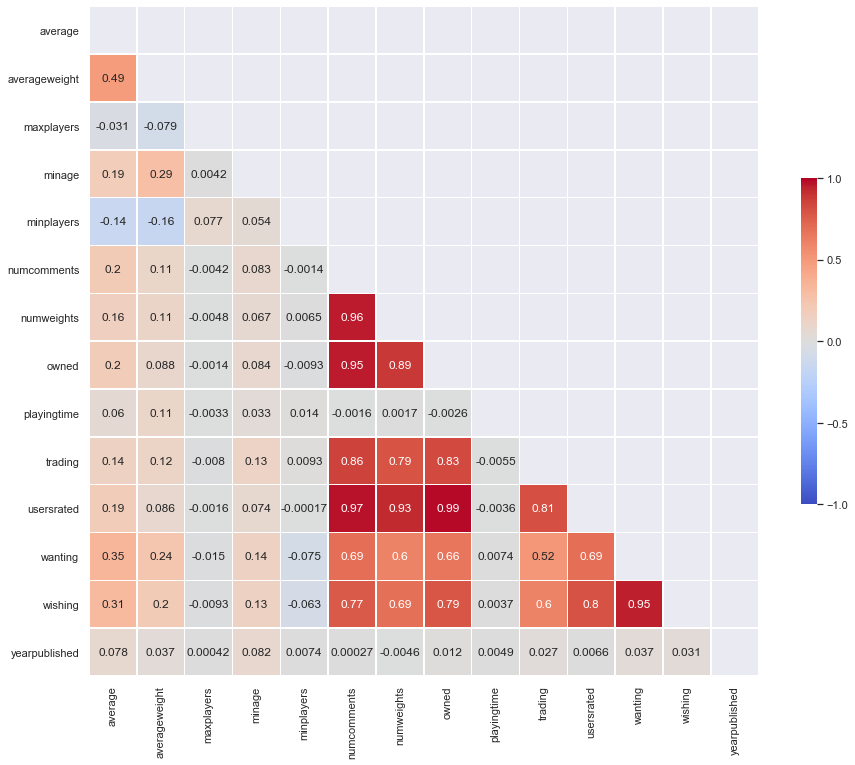

In [10]:
f, ax = plt.subplots(figsize=(15,15)) 
heatmap = sns.heatmap(corr_matrix, 
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4, 
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 12})
#add the column names as labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

Caracteristicas de la matriz de correlación:
* Number Weight: es una métrica de la comunidad BoardGameGeek que estima el grado de dificultad de comprender el juego de mesa. Mientras menor el weight más fácil el juego. Como muestra la matriz hay alta correlación con las variables número de comentarios, intercambios, compras y usuarios que califican, demuestra que mientras más fácil el juego existe mayor compra y reviews sobre él.
* Wanting: es el número de usuarios que revisaron el juego por la página. Tiene alta relación con los comentarios y compras lo que significa que por cada revisión hay alta probabilidad de compra.
* Wishing: es el número de usuarios que el juego en su wishlist. Tiene alta relación con wanting, adicionalmente con comentarios y compras, se puede asociar a que cada revisión de un juego puede llevar a agregarlo en la lista de deseos y posible compra.

Se generan los histogramas y gráficos de dispersión de cada variable mediante la libreria seaborn (pairplot).

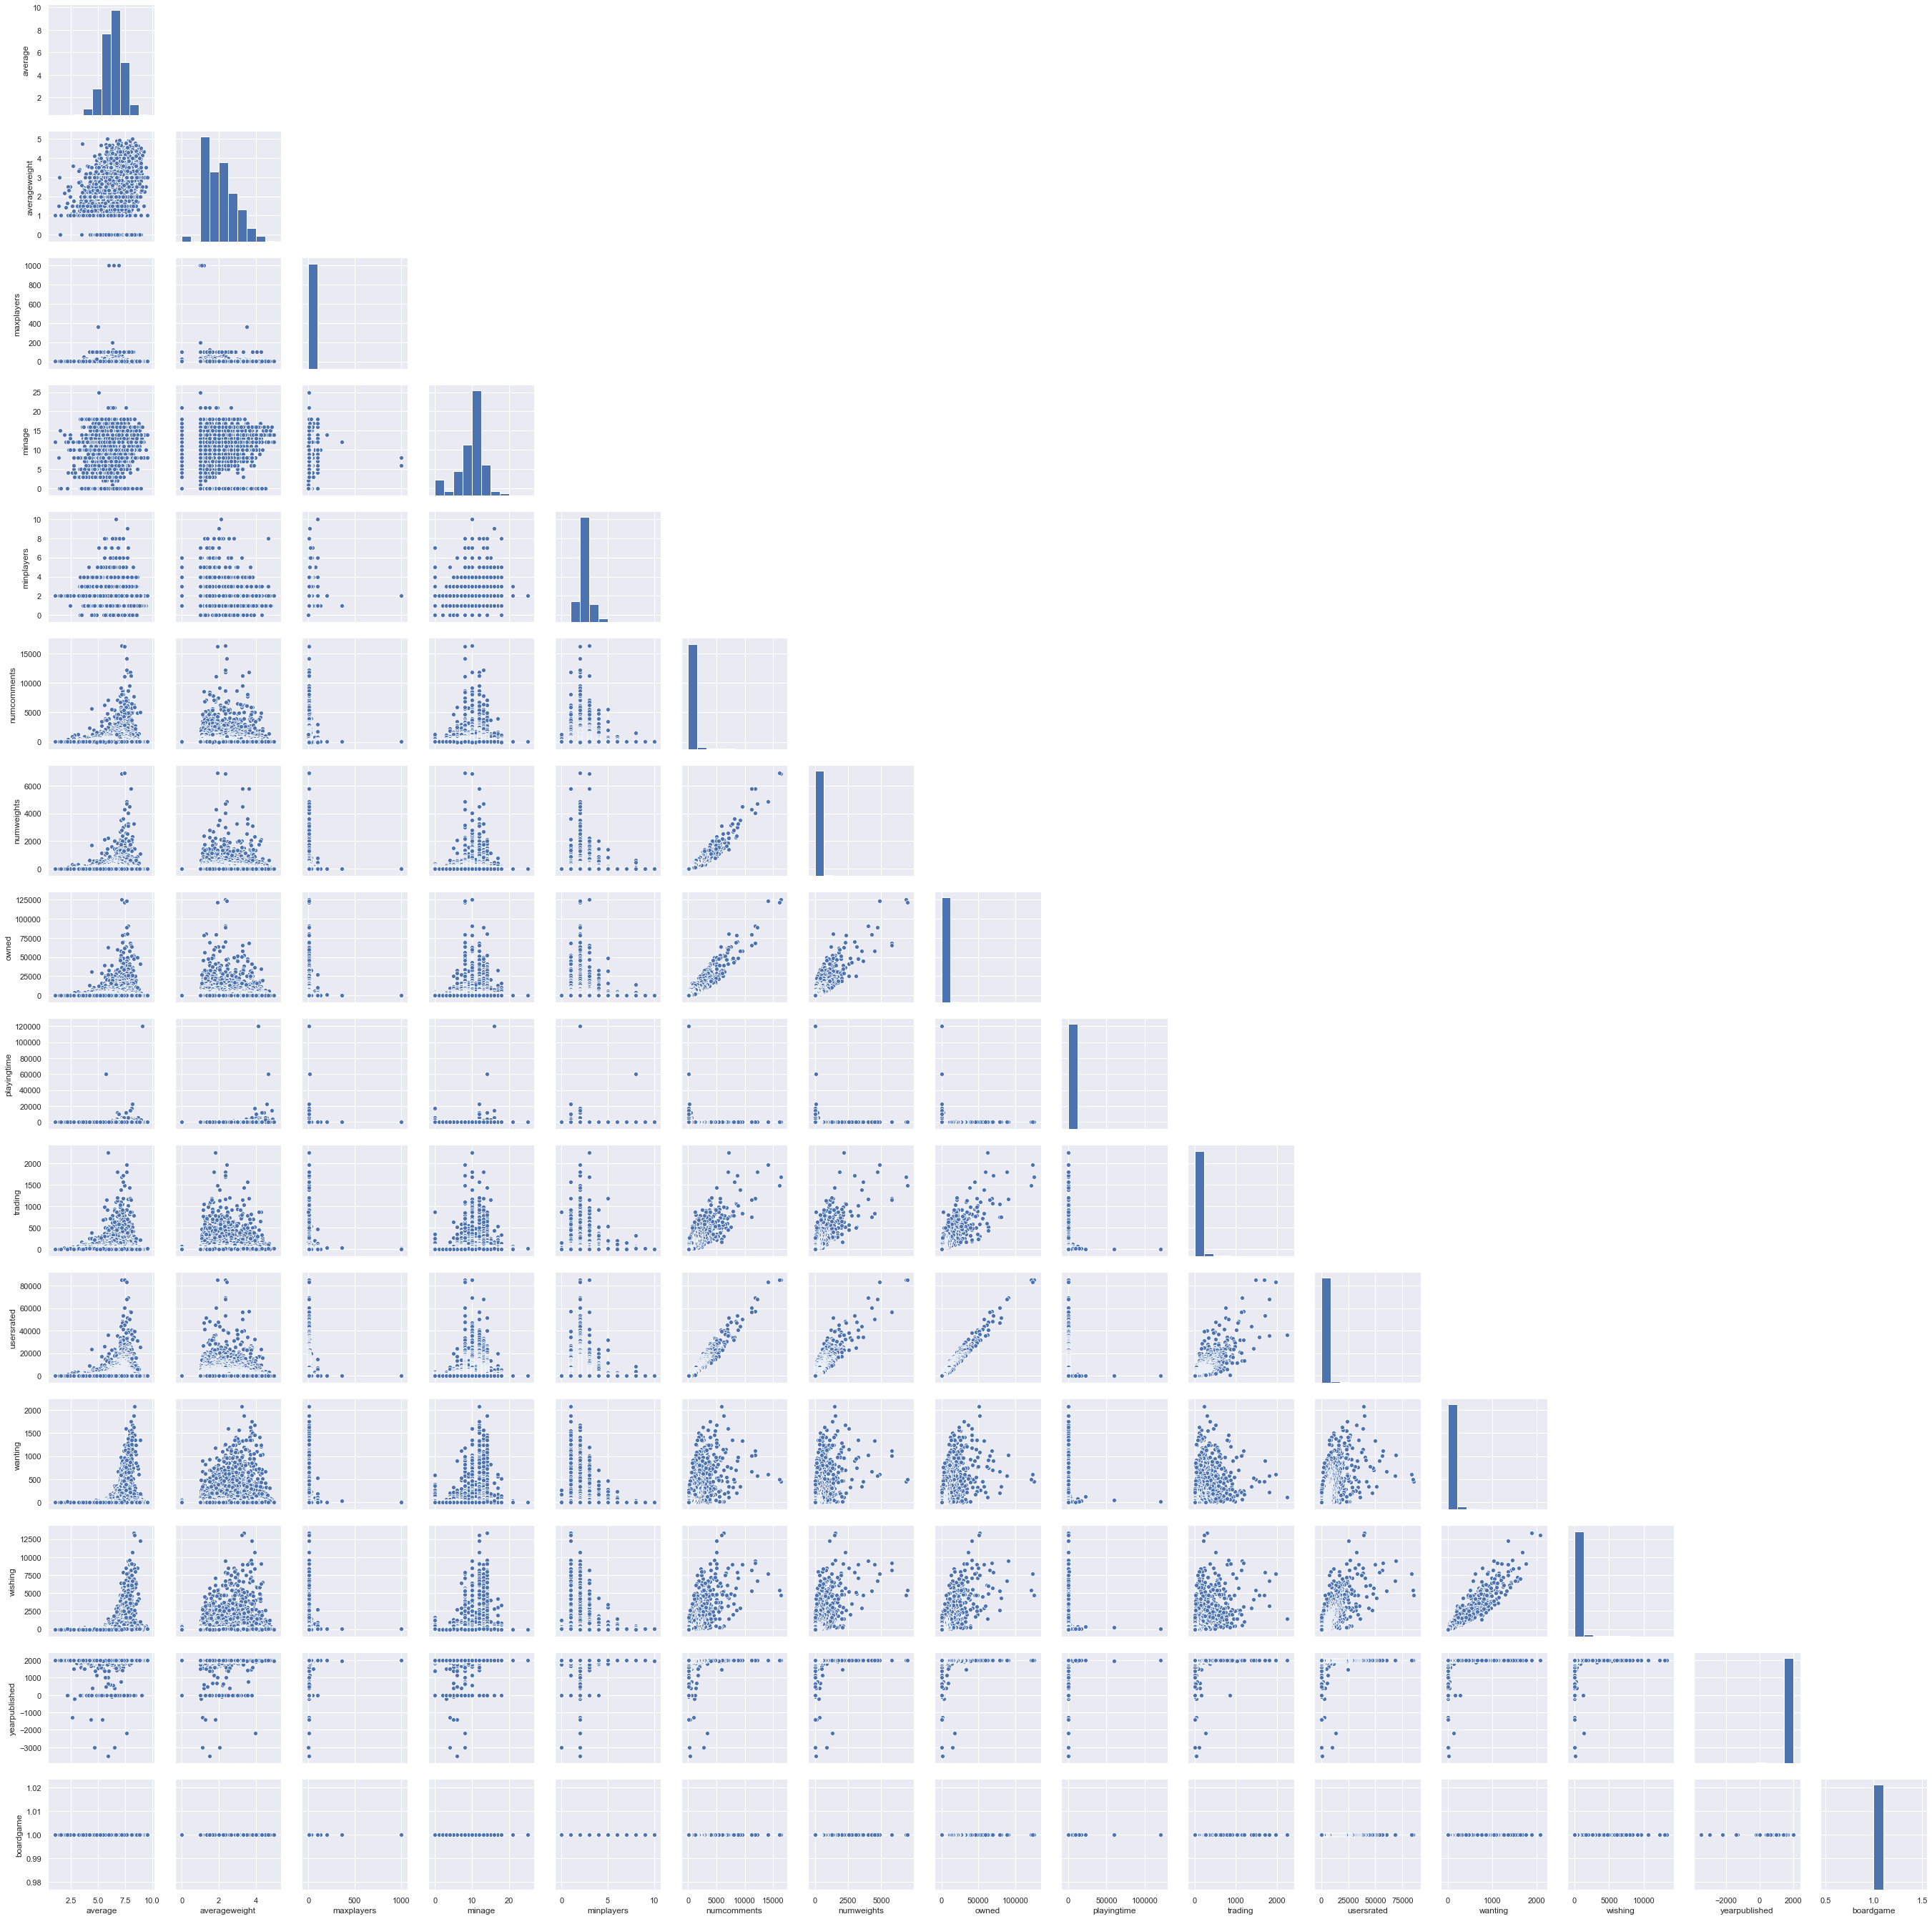

In [9]:
g = sns.pairplot(games)
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)

Se extraen las variables con alta correlación para simplificar el modelo.
Se simula grupos de datos mediante la libreria KMeans.

In [11]:
games_k = games
games_k["average"].astype('float', copy=False, inplace=True)
games_k.drop(["type","numcomments","numweights"], 
           axis=1, inplace=True)
cluster = KMeans(n_clusters=5)
cluster.fit(games)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

El siguiente gráfico compara la desviación típica y media. Muestra que varios juegos de mesa son similares (los grupos verde, naranja y azul). El grupo que se ubica más a la izquierda (azul) tiene dos casos con alta variabilidad que los otros. Sucede algo similar con el grupo de la derecha (Rojo Vino). 

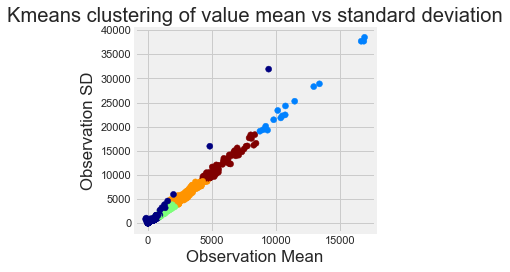

In [12]:
fig=plt.figure()
plt.style.use('fivethirtyeight')
plt.scatter(x=games_k.apply(np.mean, axis=1), 
            y=games_k.apply(np.std, axis=1),
            c=cluster.labels_, cmap='jet');
plt.xlabel('Observation Mean')
plt.ylabel('Observation SD')
plt.title('Kmeans clustering of value mean vs standard deviation')
plt.tight_layout()
plt.show()

### Data Wrangling

Sólo se utilizará la información de los juegos publicados desde 1991.

In [13]:
games = games[(games['yearpublished'] > 1990)]
print(games.shape)
games.head(5)

(14222, 13)


,average,averageweight,maxplayers,minage,minplayers,owned,playingtime,trading,usersrated,wanting,wishing,yearpublished,boardgame
0,7.19118,2.3399,4,10,3,125254,120,1685,85332,453,4729,1995,1
1,7.42605,1.9247,5,8,2,121717,45,1477,85052,498,5403,2000,1
2,7.63799,2.4220,4,8,2,123067,45,1977,83486,614,7655,2008,1
3,7.78118,2.3397,7,10,2,91037,30,1162,69132,1029,9464,2010,1
4,7.64470,2.3623,4,13,2,88729,30,1806,68284,571,6703,2008,1


## Feature Selection

Las variables son cuantitativas, el caso de tipo se convirtió en una variable dummy.

In [14]:
games.head(5)

,average,averageweight,maxplayers,minage,minplayers,owned,playingtime,trading,usersrated,wanting,wishing,yearpublished,boardgame
0,7.19118,2.3399,4,10,3,125254,120,1685,85332,453,4729,1995,1
1,7.42605,1.9247,5,8,2,121717,45,1477,85052,498,5403,2000,1
2,7.63799,2.4220,4,8,2,123067,45,1977,83486,614,7655,2008,1
3,7.78118,2.3397,7,10,2,91037,30,1162,69132,1029,9464,2010,1
4,7.64470,2.3623,4,13,2,88729,30,1806,68284,571,6703,2008,1


## Modeling

### Train and Test Subsets (Supervised Learning)

Se selecciona los subsets de train y test. Train será el 80% del dataset y Test, el 20% restante, elegidos aleatoriamente.

In [15]:
games_train = games.sample(frac = 0.8, random_state = 7)
games_test = games.loc[~games.index.isin(games_train.index)]

In [16]:
print(games_train.shape)
print(games_test.shape)

(11378, 13)
(2844, 13)


In [17]:
y_train = games_train.pop('average')
y_test = games_test.pop('average')
print(y_train.dtype)
print(y_train.shape)

float64
(11378,)


In [18]:
print(y_test.dtype)
print(y_test.shape)

float64
(2844,)


### Model Selection

Se define el modelo como una regression lineal, y se ajusta el subset de Train.

In [19]:
lr = LinearRegression()

#### Ridge Regularization

In [20]:
games_standardized = preprocessing.scale(games_train)

In [21]:
ridge_cv = linear_model.RidgeCV(cv=10, normalize=False)

In [22]:
ridge_cv.fit(games_standardized, y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=10, fit_intercept=True,
        gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [23]:
alpha_ridge = ridge_cv.alpha_
ridge_coef = ridge_cv.coef_
print(ridge_coef)

[ 0.40445241  0.0087486   0.00553351 -0.03998857  0.39483498  0.01955423
 -0.10619423 -0.18708603  0.41716204 -0.33500614  0.31031064  0.        ]


In [24]:
ridge_cv = linear_model.Ridge(alpha=alpha_ridge, random_state = 7)

In [25]:
ridge_cv.fit(games_standardized, y_train)

Ridge(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=7, solver='auto', tol=0.001)

In [26]:
cv_score_ridge = cross_val_score(ridge_cv, games_standardized,
                                 y_train, cv=10,
                                 scoring='neg_mean_squared_error')
rmse_ridge = np.mean(-cv_score_ridge) ** (0.5)
rmse_ridge

0.6796300660324781

#### Lasso Regularization

In [27]:
lasso_cv = linear_model.LassoCV(cv = 10, normalize = False,
                                verbose = True, random_state = 7)

In [28]:
lasso_cv.fit(games_standardized, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=7, selection='cyclic',
        tol=0.0001, verbose=True)

In [29]:
alpha_lasso = lasso_cv.alpha_
lasso_coef = lasso_cv.coef_
print(lasso_coef)

[ 0.40414506  0.00436302  0.00181992 -0.03788543  0.12793397  0.01616175
 -0.06332428 -0.          0.27603634 -0.16311081  0.30782888  0.        ]


In [30]:
lasso = linear_model.Lasso(alpha = alpha_lasso,
                           random_state = 7)

In [31]:
lasso.fit(games_standardized, y_train)

Lasso(alpha=0.004153288346813445, copy_X=True, fit_intercept=True,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=7, selection='cyclic', tol=0.0001, warm_start=False)

In [32]:
cv_score_lasso = cross_val_score(lasso_cv, games_standardized,
                                 y_train, cv = 10,
                                 scoring = 'neg_mean_squared_error',
                                 verbose = 0)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [33]:
rmse_lasso = np.mean(-cv_score_lasso) ** (0.5)
rmse_lasso

0.681147284293343

### Tuning Parameters

#### Model Metrics

Ambos modelos regularizados por Ridge y Lasso tienen resultados similares. Ridge parece más robusto por que provee una solución, en cambio Lasso entrega un conjunto de posibles soluciones.
A continuación, se calcula la diferencia entre los coeficientes de ambas propuestas.

In [34]:
difference = np.absolute(np.subtract(lasso_coef, ridge_coef))
print(difference)

[0.00030735 0.00438558 0.00371359 0.00210313 0.26690101 0.00339248
 0.04286996 0.18708603 0.1411257  0.17189533 0.00248175 0.        ]


El coeficiente de la variable owned tiene mayor diferencia en las pruebas. Es posible que sea debido a la correlación.